In [2]:
import Models
import numpy as np
import random as rn
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

rn.seed(1)
np.random.seed(1)
tf.random.set_seed(1)
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

# Load Data
X_brca_mRNA_data = pd.read_csv('./BRCA_mRNA.txt', sep=',', index_col=0) # Dataset has Donor ID as first column
X_brca_CNA_data = pd.read_csv('./BRCA_CNA.txt', sep=',' ,index_col=0) # Dataset has Donor ID as first column
y_brca_data = pd.read_csv('./BRCA_Clinical.txt', sep=',', index_col=0, names=["Label"]) # Dataset has Donor ID on first column and Label on second column.

X_brca_mRNA_filtered = X_brca_mRNA_data.drop(["TCGA-AO-A12C-01","TCGA-AR-A1AT-01","TCGA-BH-A18V-06"], axis=1)
X_brca_CNA_filtered = X_brca_CNA_data.drop(["TCGA-AR-A0U1-01"], axis=1)
y_brca_filtered = y_brca_data.drop(["TCGA-AO-A12C-01","TCGA-AR-A1AT-01","TCGA-BH-A18V-06"], axis=0)


X_train_first_norm, X_train_second_norm, X_swapped_first_norm, X_swapped_second_norm, X_test_first_norm, X_test_second_norm, X_train_concat, X_swapped_concat, X_test_concat, y_train, y_test, y_train_oh, y_test_oh \
    = Models.prepare_datasets(X_brca_mRNA_filtered.T,X_brca_CNA_filtered.T, y_brca_filtered, test_size=0.2, swap_noise=0.15)

# CONCAT TRAIN AND TEST DATASET TO TRANSFORM THE ENTIRE DATA (FOR KPCA)
X_first = pd.concat([X_train_first_norm, X_test_first_norm], axis=0)
X_second = pd.concat([X_train_second_norm, X_test_second_norm], axis=0)
y = pd.concat([y_train, y_test], axis=0)


swapping: 20 rows.


In [ ]:
import importlib
importlib.reload(Models)

Compression: 105.88

Epoch 00051: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00068: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00082: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00087: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 00093: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.

Epoch 00098: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.
Epoch 00098: early stopping


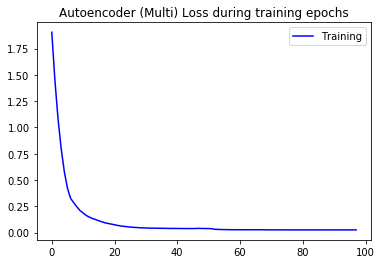

0.025982231675432278


TypeError: build_and_train_autoencoder() missing 1 required positional argument: 'validation_data'

In [6]:
## Build and Train Multi Autoencoder
autoencoder, encoder, decoder, loss = Models.build_and_train_multi_autoencoder([X_train_first_norm,X_train_second_norm],
                                                              [X_train_first_norm,X_train_second_norm],
                                                              encoding_dim=100, 
                                                              regularizer=tf.keras.regularizers.l1_l2(0.00005,0.000003),
                                                              dropout=0.25,
                                                              epochs=200,
                                                              mu=0.1)
## Encode datasets
X_latent_multi_ae = Models.encode_dataset([X_train_first_norm,X_train_second_norm], encoder)
X_latent_test_multi_ae = Models.encode_dataset([X_test_first_norm,X_test_second_norm], encoder)

## Build and Train Autoencoder
autoencoder, encoder, decoder, loss = Models.build_and_train_autoencoder(X_train_concat,
                                                              X_train_concat,
                                                              encoding_dim=100, 
                                                              regularizer=tf.keras.regularizers.l1_l2(0.000005,0.000005),
                                                              dropout=0.2,
                                                              epochs=200,
                                                              validation_data=None)
## Encode datasets
X_latent_ae = Models.encode_dataset(X_train_concat, encoder)
X_latent_test_ae = Models.encode_dataset(X_test_concat, encoder)

## Build and Train Multi Denoising Autoencoder
autoencoder, encoder, decoder, loss = Models.build_and_train_multi_autoencoder([X_swapped_first_norm,X_swapped_second_norm],
                                                              [X_train_first_norm,X_train_second_norm],
                                                              encoding_dim=100, 
                                                              regularizer=tf.keras.regularizers.l1_l2(0.000005,0.000005),
                                                              dropout=0,
                                                              epochs=200,
                                                              mu=0.5)
## Encode datasets
X_latent_multi_dae = Models.encode_dataset([X_train_first_norm,X_train_second_norm], encoder)
X_latent_test_multi_dae = Models.encode_dataset([X_test_first_norm,X_test_second_norm], encoder)

## Build and Train Denoising Autoencoder
autoencoder, encoder, decoder, loss = Models.build_and_train_autoencoder(X_swapped_concat,
                                                              X_train_concat,
                                                              encoding_dim=100, 
                                                              regularizer=tf.keras.regularizers.l1_l2(0.000005,0.000005),
                                                              dropout=0.2,
                                                              epochs=200)
## Encode datasets
X_latent_dae = Models.encode_dataset(X_train_concat, encoder)
X_latent_test_dae = Models.encode_dataset(X_test_concat, encoder)

# Perform rbf kernel to divided datasets
X_kpca, _ = Models.perform_multi_KPCA(X_first, X_second, y, gamma=0.008, mu=0.8)

# Split into train and test sets
X_latent_kpca, X_latent_test_kpca, y_train_kpca, y_test_kpca = train_test_split(X_kpca, y, test_size=0.2, random_state=1) 

In [ ]:
### CLASSIFICATION ###
# We use the reduced datasets to train a classifier and compare them.
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)
# Original Concatenated Dataset Classification 
original_classify = Models.classify_with_cv(X_train_concat, X_test_concat, y_train, y_test, model_type="Original")
# Multi-AE Classification
multi_ae_classify = Models.classify_with_cv(X_latent_multi_ae, X_latent_test_multi_ae, y_train, y_test, model_type="Multi-AE")
# AE Classification
ae_classify = Models.classify_with_cv(X_latent_ae, X_latent_test_ae, y_train, y_test, model_type="AE")
# Multi-DAE Classification
multi_dae_classify = Models.classify_with_cv(X_latent_multi_dae, X_latent_test_multi_dae, y_train, y_test, model_type="Multi-DAE")
# DAE Classification
dae_classify = Models.classify_with_cv(X_latent_dae, X_latent_test_dae, y_train, y_test, model_type="DAE")
# KPCA Classification
kpca_classify = Models.classify_with_cv(X_latent_kpca, X_latent_test_kpca, y_train, y_test, model_type="KPCA")

In [ ]:
###### CLUSTERING ###
original_clustering = Models.cluster(X_train_concat, y_train, model_type="Original")
# Multi-AE Clustering
multi_ae_clustering = Models.cluster(X_latent_multi_ae, y_train, model_type="AE")
# AE Clustering
ae_clustering = Models.cluster(X_latent_ae, y_train, model_type="AE")
# Multi-DAE Clustering
multi_dae_clustering = Models.cluster(X_latent_multi_dae, y_train, model_type="AE")
# DAE Clustering
dae_clustering = Models.cluster(X_latent_dae, y_train, model_type="AE")
# KPCA Clustering
kpca_clustering = Models.cluster(X_latent_kpca, y_train, model_type="AE")


In [ ]:
results = [original_classify + original_clustering, multi_ae_classify + multi_ae_clustering, ae_classify + ae_clustering, multi_dae_classify + multi_dae_clustering, dae_classify + dae_clustering, kpca_classify + kpca_clustering]
scores = pd.DataFrame(results, index=["Original","Multi-AE","AE","Multi-DAE","DAE","KPCA"],
                      columns=["LR accuracy","SVM accuracy", "RF accuracy", "LR ROC-AUC", "SVM ROC-AUC", "RF ROC-AUC","KMeans Silhouette","Spectral Silhouette","Hierarchical Silhouette","KMeans MI","Spectral MI","Hierarchical MI"])    
scores

In [ ]:
data_acc = scores[["LR accuracy","SVM accuracy","RF accuracy"]]
sns.set()

ax = sns.lineplot(data=data_acc)
plt.legend(fontsize='small')
ax.set_xlabel(f"model")
ax.set_ylabel(f"accuracy")
ax.figure.set_size_inches(10 , 5)
ax.set_title(f"model vs accuracy")
plt.show()
